# BlackJack


- Objective of the game is to obtain cards, sum of whose numerical values is as great as possible without exceeding 21.
- All face cards (King, Queen, Jack), have a numerical value of 10.
- Ace can either be 1 or 11.
- Number cards have value equal to its number
- There is dealer the player is playing with.
- The game begins with two cards dealt to both dealer and player. One of the dealers card is face up and another is face down. If player has 21 immediately (a 10 and an Ace), its caller natural. He then wins, unless dealer also has a natural, in which case, it is draw. If the player does not have a natural, then he can request additional cards one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If player goes bust, he loses; if he sticks then it becomes the dealer's turn. The dealer hits or sticks according to some strategy. If the dealer goes bust, then the player wins; otherwise the outcome - win, lose or draw is determined by whose final sum is closer to 21.
	
	
- Modeling it as MDP:
	* Each game can be seen as an episode.
	* Our player is the agent and the dealer can be seen as the component of environment. For ease of explanation, we'll fix the strategy for the dealer. The dealer sticks on any sum of 17 or greater, and hits otherwise. Since the dealer is part of the environment, the agent doesn't have access to this strategy directly.
	* Rewards of +1, -1 or 0 given at the end of the episode, for a win, lose or draw respectively.
	* We assume that the cards are drawn from an infinite deck, so there's no advantage to keeping track of cards already dealt.
	* The episodes are undiscounted.
	* The state is made of three variables:
		- The current sum of agent (12-21)
		- Dealer's one showing card (Ace-10)
		- Usable Ace (Yes or No) [If player holds an ace which can be used as 11 without going bust then it is called an usable ace].
	* Actions can be:
		- Hit (Request a card)
		- Stick (Stop requesting card. Give turn to the dealer)


In [1]:
import gym
import numpy as np
from typing import Callable, List, Tuple, Sequence
from collections import defaultdict
import sys
import plots
import matplotlib.pyplot as plt

%matplotlib inline

### Understanding the OpenAI's Blackjack Environment

OpenAI's implementation of the [Blackjack](https://gym.openai.com/envs/Blackjack-v0/) game environment as described in the (Example 5.1 of [Reinforcement Learning: An Introduction book](http://incompleteideas.net/book/RLbook2018.pdf)).

Learn mote about OpenAI gym [here](https://gym.openai.com/)

In [2]:
env = gym.make('Blackjack-v0')

The state is represented as tuple of three values : 
- Player's sum : {0,1,....,31}
- Dealer's card : {0,1,2,....,10} (1 is Ace)
- Usable ace : {True, False}

In [3]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

Two actions are permisible in the environment

- Hit : 1
- Stick : 0

In [4]:
env.action_space

Discrete(2)

In [5]:
for i_episode in range(10):
    state = env.reset()  
    for t in range(100):
        players_sum, dealers_card, usable_ace = state
        print("Player's sum : {}\t| Dealer's card : {}\t| Usable ace : {}".format(players_sum, dealers_card, usable_ace))
        action = env.action_space.sample()
        print("Players action : {}".format("Hit" if action==1 else "Stick"))
        state, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            players_sum, dealers_card, usable_ace = state
            print("Player's sum : {}\t| Dealer's card : {}\t| Usable ace : {}".format(players_sum, dealers_card, usable_ace))
            print("Final reward : {}\n\n".format(reward))
            break
env.close()

Player's sum : 9	| Dealer's card : 3	| Usable ace : False
Players action : Hit
Player's sum : 19	| Dealer's card : 3	| Usable ace : False
Players action : Stick
Episode finished after 2 timesteps
Player's sum : 19	| Dealer's card : 3	| Usable ace : False
Final reward : 1.0


Player's sum : 12	| Dealer's card : 10	| Usable ace : False
Players action : Hit
Episode finished after 1 timesteps
Player's sum : 22	| Dealer's card : 10	| Usable ace : False
Final reward : -1


Player's sum : 18	| Dealer's card : 8	| Usable ace : False
Players action : Stick
Episode finished after 1 timesteps
Player's sum : 18	| Dealer's card : 8	| Usable ace : False
Final reward : -1.0


Player's sum : 19	| Dealer's card : 10	| Usable ace : False
Players action : Hit
Episode finished after 1 timesteps
Player's sum : 27	| Dealer's card : 10	| Usable ace : False
Final reward : -1


Player's sum : 13	| Dealer's card : 8	| Usable ace : False
Players action : Stick
Episode finished after 1 timesteps
Player's sum : 13

### On-policy Monte-Carlo prediction (First-visit method)

<img src="images/M4A1-P1.png" alt="M4A1-P3" width="500"/>

In [6]:
class monte_carlo_prediction_first_visit(object):
    def __init__(self, env : gym.envs, policy : Callable[[Tuple], int], \
                 num_episodes : int = 50000, gamma : float = 1.0) -> None:
        '''
        @parameters
        env           :      Object of the gym environment
        policy        :      Deterministic policy to be evaluated. 
                             In the form of function, to which when a state is passed, an action is returned.
        num_episodes  :      Number of episodes to be generated for the algorithm.
        gamma         :      Discount factor used while calculating return
        
        @doc
        This function initializes all the class variables. State value function is initialized as an empty dictionary.
        Another dictionary is created to story number of visits to each state.
        '''
        self.policy = policy
        self.num_episodes = num_episodes
        self.gamma = gamma
        self.env = env
        self.V = defaultdict(float)
        self.N = defaultdict(int)
        
    
    def generate_episode(self, max_episode_len : int = 100000) -> list:
        '''
        One episode is generated using the given policy. A list with the (state, action, reward) sequence is returned.
        '''
        episode = []
        state = env.reset()
        for _ in range(max_episode_len):
            action = self.policy(state)
            new_state, reward, done, info = env.step(action)
            episode.append((state, action, reward))
            if done:
                return episode
            state = new_state
        return episode
            
    
    def estimate_state_value_function(self) -> defaultdict:
        '''
        Implementation of MC prediction (first-visits). The final value estimates for all states is returned as a dictionary.
        '''
        for episode_num in range(self.num_episodes):
            if(((episode_num+1)%1000) == 0):
                print("\rEpisode {}/{}".format(episode_num+1,self.num_episodes), end = "")
                sys.stdout.flush()
            episode = self.generate_episode()
            G = 0
            all_states = np.array(episode)[:,0]
            for time_step in reversed(range(len(episode))):
                state, action, reward = episode[time_step]
                G = self.gamma * G + reward
                if (state not in all_states[0:time_step].tolist()):
                    self.N[state] = self.N[state] + 1
                    self.V[state] = self.V[state] + (1.0/self.N[state]) * (G - self.V[state])
        return self.V
                

Episode 10000/10000

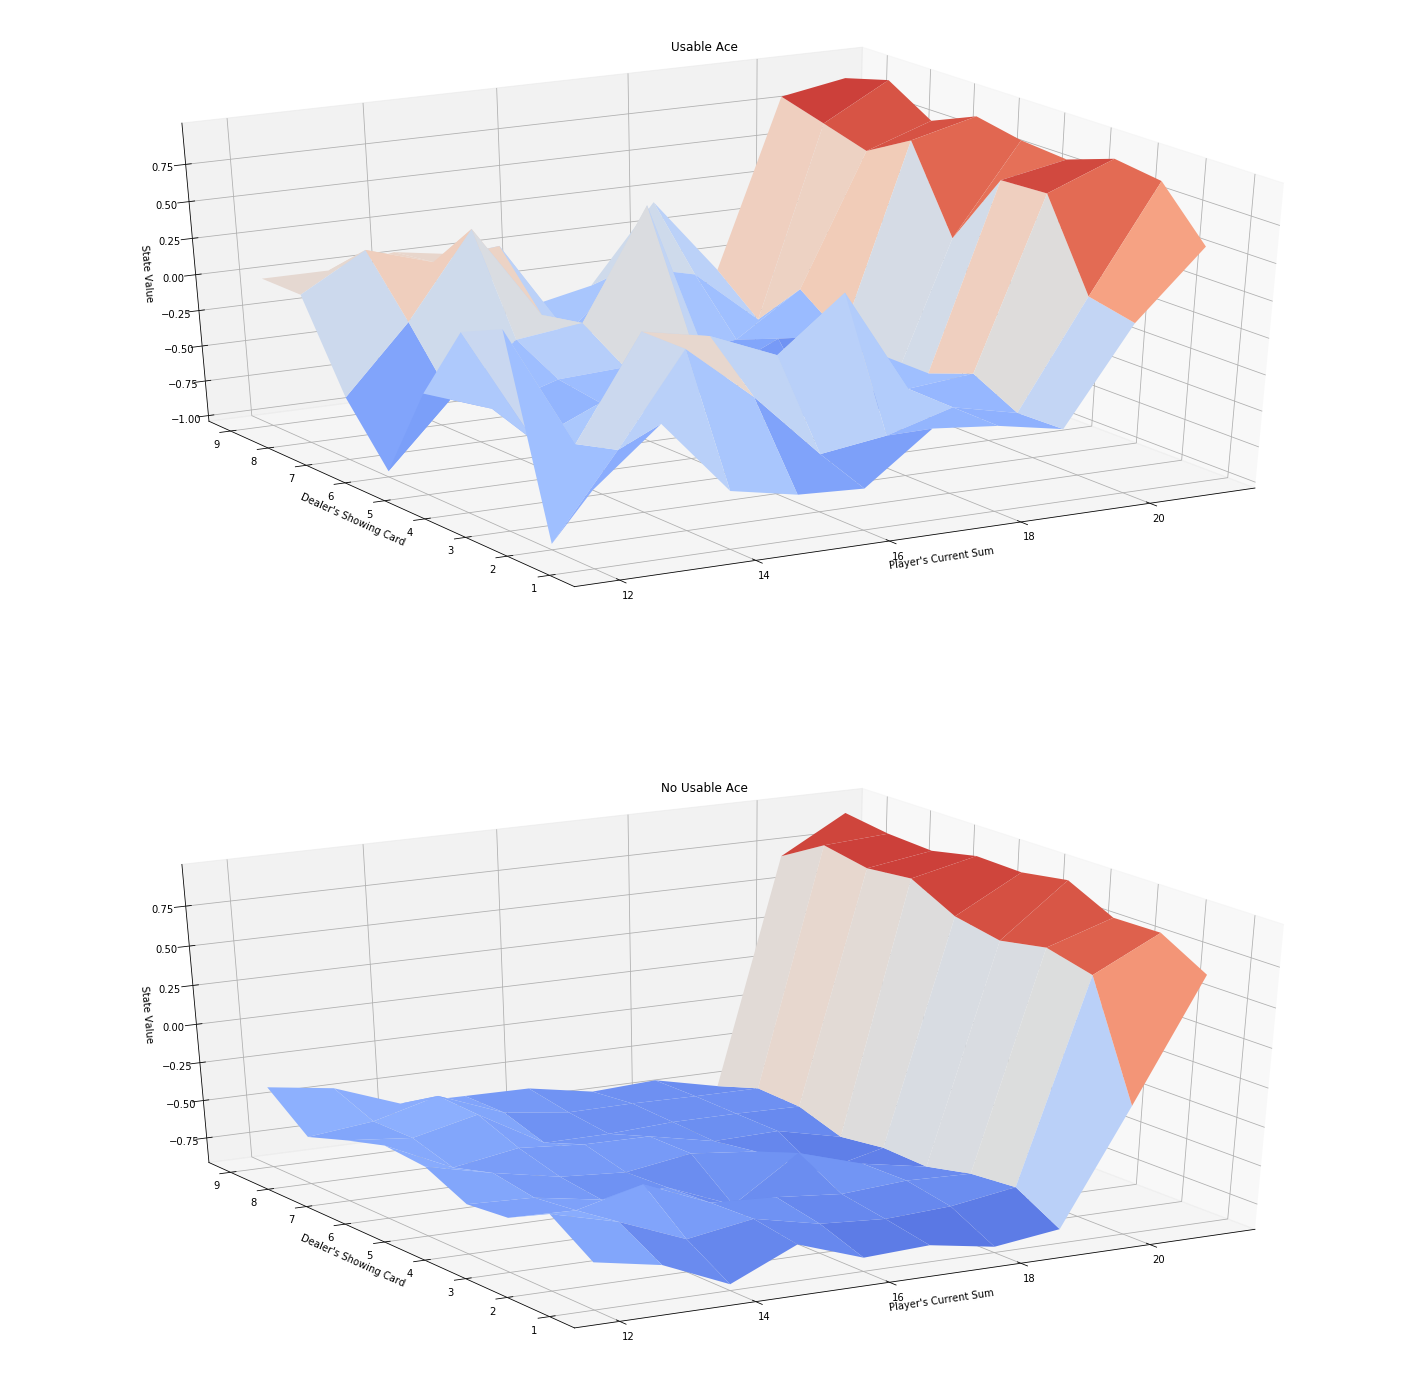

In [7]:
def policy(state):
    '''
    Policy to be evaluated. Stick only if sum is greater or equal to 20.
    '''
    if(state[0]>=20):
        return 0
    else:
        return 1
    
mc_prediction_obj = monte_carlo_prediction_first_visit(env, policy, num_episodes=10000)
V = mc_prediction_obj.estimate_state_value_function()
plots.plot_blackjack_values(V)

Episode 500000/500000

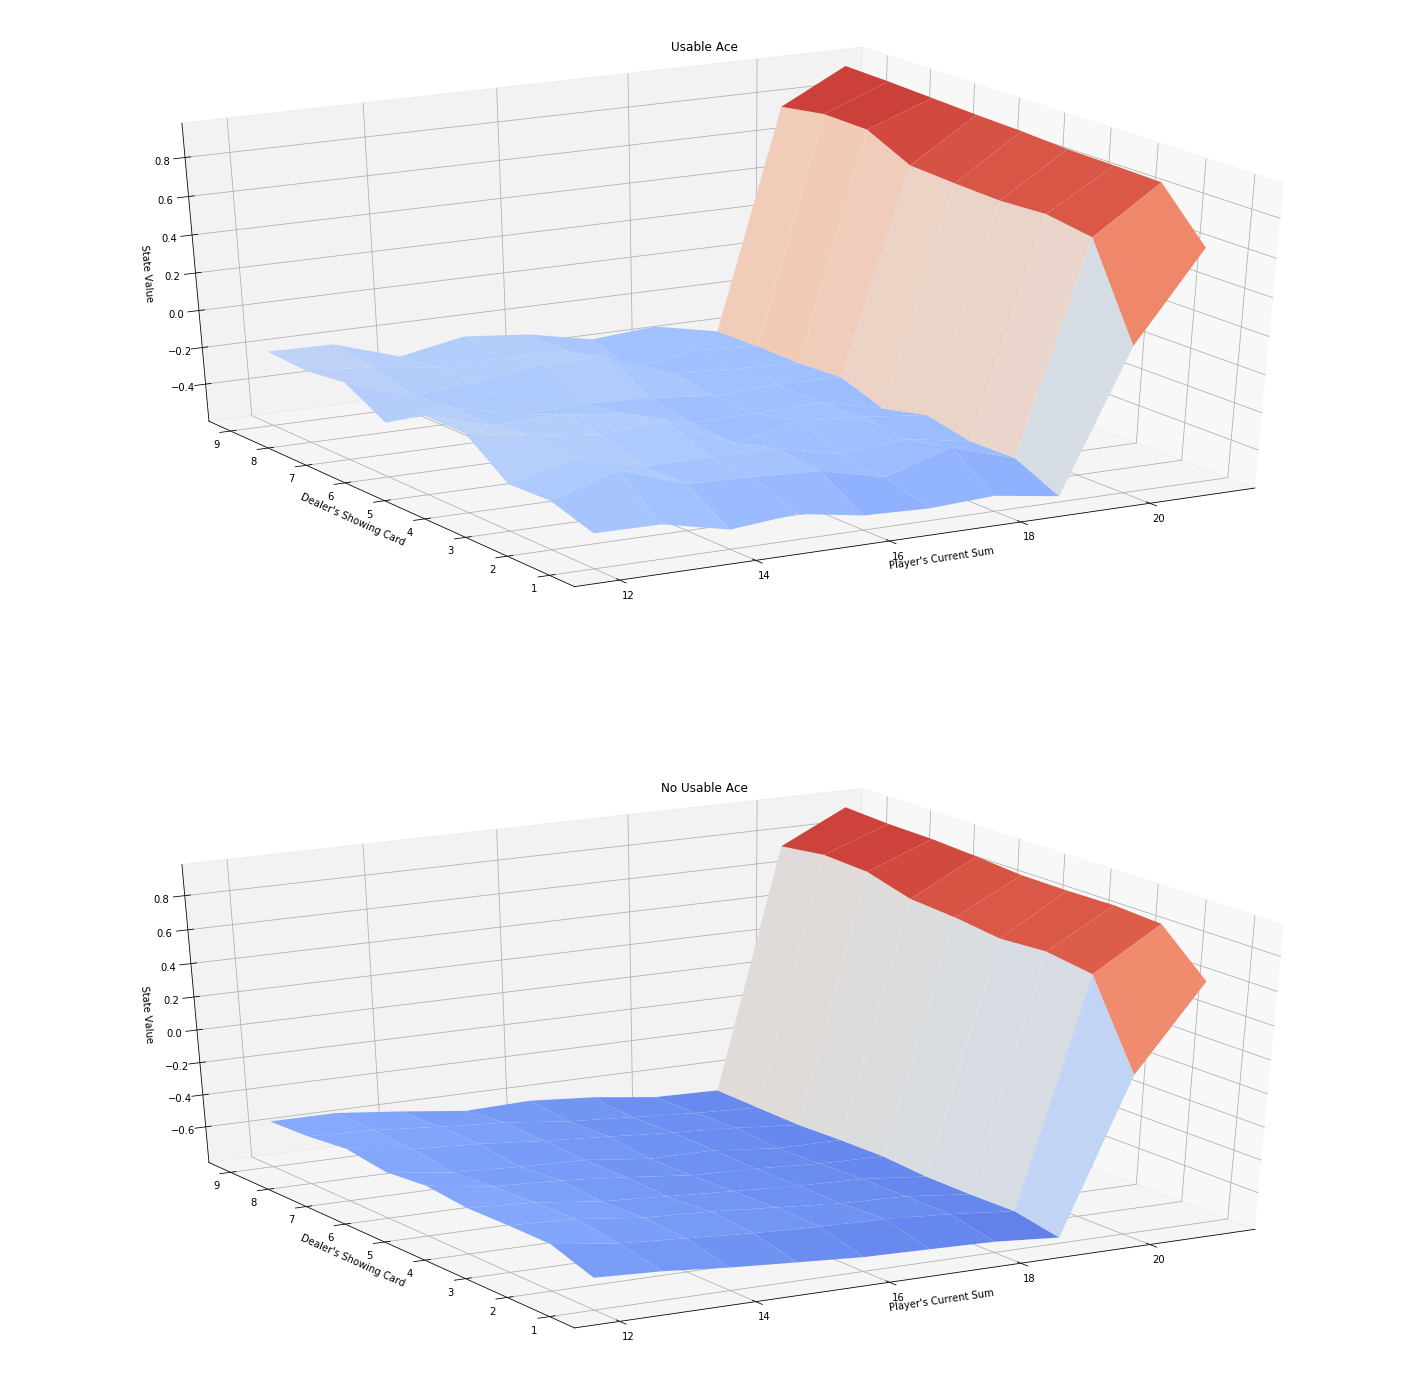

In [8]:
mc_prediction_obj = monte_carlo_prediction_first_visit(env, policy, num_episodes=500000)
V = mc_prediction_obj.estimate_state_value_function()
plots.plot_blackjack_values(V)

### On-policy Monte-Carlo control (Epsilon soft policies)

<img src="images/M4A1-P3.png" alt="M4A1-P3" width="500"/>

In [ ]:
class monte_carlo_control_epsilon_soft(object):
    def __init__(self, env : gym.envs, num_episodes : int = 500000, gamma : float = 1.0, epsilon : float = 0.05) -> None:
        '''
        @parameters
        env           :      Object of the gym environment
        num_episodes  :      Number of episodes to be generated for the algorithm.
        gamma         :      Discount factor used while calculating return
        epsilon       :      A small float value (<=1)
        
        @doc
        This function initializes all the class variables. Action value function is initialized as an empty dictionary.
        Another dictionary is created to story number of visits to each state,action pair. 
        Initial policy is a equiprobable random policy.
        '''
        
        '''
        Implement this
        '''
        
        pass
    
    def generate_episode(self, max_episode_len : int = 100000) -> list:
        '''
        One episode is generated using the current policy. A list with the (state, action, reward) sequence is returned.
        '''
        
        '''
        Implement this
        '''
        pass
        
    
    def find_optimal_soft_policy(self) -> (defaultdict,defaultdict):
        '''
        Implementation of MC control (first-visits, epsilon-soft policies). 
        The final action value estimates for all state,action is returned as a dictionary.
        Also the optimal soft policy is returned as dictionary, where key is the state and value is a list with probabilities for possible actions.
        '''
        
        '''
        Implement this
        '''
        pass

In [ ]:
mc_control_agent = monte_carlo_control_epsilon_soft(env)
Q, policy = mc_control_agent.find_optimal_soft_policy()
policy_with_determinstic_action = dict([(k,np.argmax(v)) for k,v in policy.items()])
V = dict([(k, max(v)) for k,v in Q.items()])
plots.plot_blackjack_policy(policy_with_determinstic_action)
plots.plot_blackjack_values(V)

### Off-policy Monte-Carlo Conrol

<img src="images/M4A1-P4.png" alt="M4A1-P3" width="500"/>

In [ ]:
class monte_carlo_control_off_policy(object):
    def __init__(self, env : gym.envs, num_episodes : int = 500000, gamma : float = 0.9) -> None:
        '''
        @parameters
        env           :      Object of the gym environment
        num_episodes  :      Number of episodes to be generated for the algorithm.
        gamma         :      Discount factor used while calculating return
        
        @doc
        This function initializes all the class variables. Action value function is initialized as an empty dictionary.
        Another dictionary is created to story number of visits to each state,action pair. 
        Target policy is a deteminstic policy. Behaviour policy is a epsilon-greedy policy
        '''
        
        '''
        Implement this
        '''
        pass
    
    def get_behavior_policy(self) -> Callable[[Tuple, float], float]:
        '''
        This function return another function 'select_action_probabs'
        '''
        def select_action_probabs(state : Tuple, epsilon : float = 0.05):
            '''
            @parameters
            state  :   Tuple for state representation
            
            @doc
            This function returns action probabilities for the given state. 
            The action probabilities are epsilon-soft wrt the target policy.
            '''
            
            '''
            Implement this
            '''
            
            pass
        return select_action_probabs
    
    
    def generate_episode(self, max_episode_len : int = 100000) -> list:
        '''
        One episode is generated using the behaviour policy. A list with the (state, action, reward) sequence is returned.
        '''
        
        '''
        Implement this
        '''
        
        pass
    
    def find_optimal_policy(self) -> (defaultdict,defaultdict):
        '''
        Implementation of off-policy MC control. 
        The final action value estimates for all state,action is returned as a dictionary.
        Also the optimal target policy is returned as dictionary.
        '''
        
        '''
        Implement this
        '''
        pass 
    
    

In [ ]:
mc_control_off_policy_agent = monte_carlo_control_off_policy(env)
Q, policy = mc_control_off_policy_agent.find_optimal_policy()
V = dict([(k, max(v)) for k,v in Q.items()])
plots.plot_blackjack_policy(policy)
plots.plot_blackjack_values(V)